In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [88]:
train_photo = cv2.imread('inputs/desk/pa2.jpg')
train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('inputs/desk/pa1.jpg')
query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

### Viewing the Images

Text(0.5, 0, 'Train Photo')

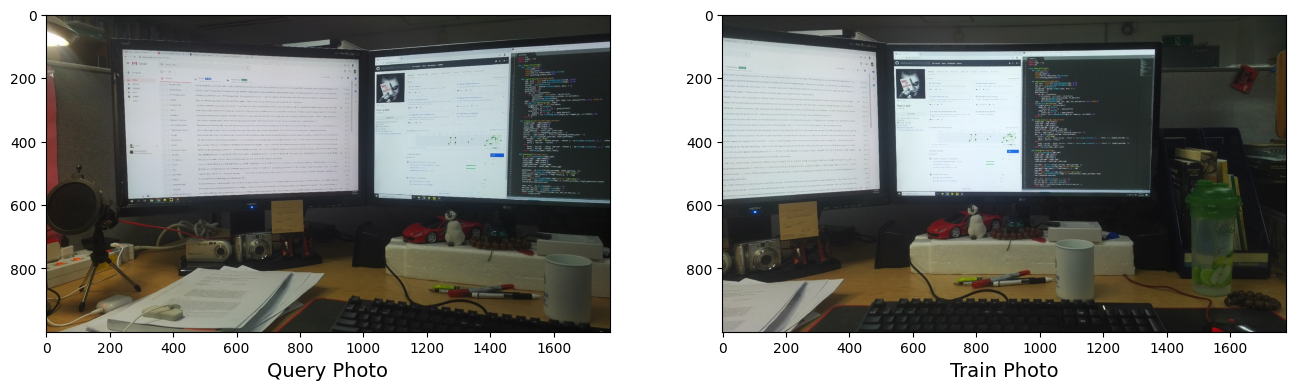

In [89]:
fig, ax = plt.subplots(1,2, constrained_layout = False, figsize=(16, 9))
ax[0].imshow(query_photo, cmap = 'gray')
ax[0].set_xlabel("Query Photo", fontsize=14)

ax[1].imshow(train_photo, cmap = 'gray')
ax[1].set_xlabel("Train Photo", fontsize=14)

In [90]:
def sift_detector(image):
    descriptor = cv2.SIFT_create()
    keypoints, features = descriptor.detectAndCompute(image, None)
    
    return keypoints, features

keypoints_train_image, features_train_image = sift_detector(train_photo_gray) 
keypoints_query_image, features_query_image = sift_detector(query_photo_gray)    
print(f'lenght the keypoints: {len(keypoints_train_image)}') 
print(f'descriptor shape: {features_train_image.shape}')

lenght the keypoints: 2402
descriptor shape: (2402, 128)


In [91]:
for keypoint in keypoints_query_image:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

print(f'x, y: {x, y}')
print(f"size: {size}")
print(f"orientation: {orientation}")
print(f"response: {response}")
print(f"octave: {octave}")
print(f"class_id: {class_id}")

x, y: (1773.96533203125, 893.0198974609375)
size: 2.397500514984131
orientation: 276.5923156738281
response: 0.01514211855828762
octave: 4195071
class_id: -1


In [92]:
features_query_image.shape 
len(keypoints_query_image)

2467

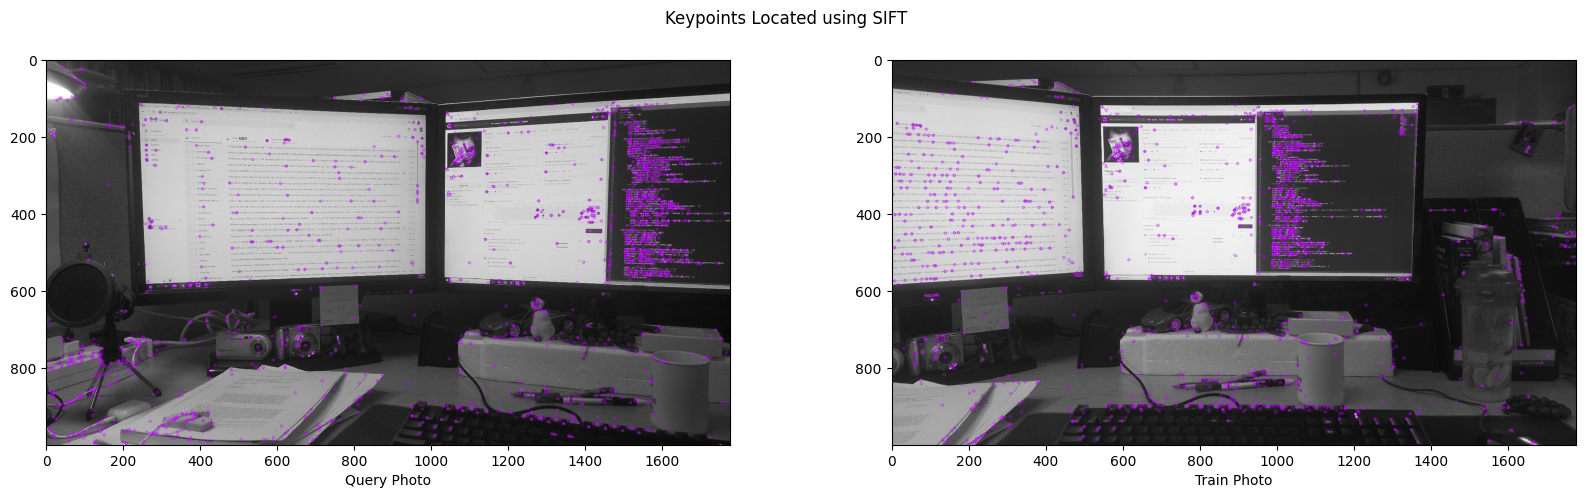

In [93]:
fig, ax = plt.subplots(1,2, figsize=(20,5), constrained_layout=False)

ax[0].imshow(cv2.drawKeypoints(query_photo_gray, keypoints_query_image, None, color = (191, 0, 255)))
ax[0].set_xlabel("Query Photo")

ax[1].imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_image, None, color = (191 , 0, 255)))
ax[1].set_xlabel("Train Photo")

plt.suptitle("Keypoints Located using SIFT")
plt.savefig('./outputs/'+ 'sift' + '_features_located' + '.jpeg', bbox_inches='tight', dpi=300, format='jpeg')

### Matching keypoints

In [94]:
def create_match():
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return bf

In [95]:
def keypoints_matching(features_train_image, features_query_image):
    bf = create_match()
    
    best_matches = bf.match(features_train_image, features_query_image)
    
    raw_matches = sorted(best_matches, key = lambda x: x.distance)
    print(f"raw matchines with brute force: {len(raw_matches)}")
    
    return raw_matches

drawing matches for bf
raw matchines with brute force: 919
matches: < cv2.DMatch 0x7ea7a4de5930>


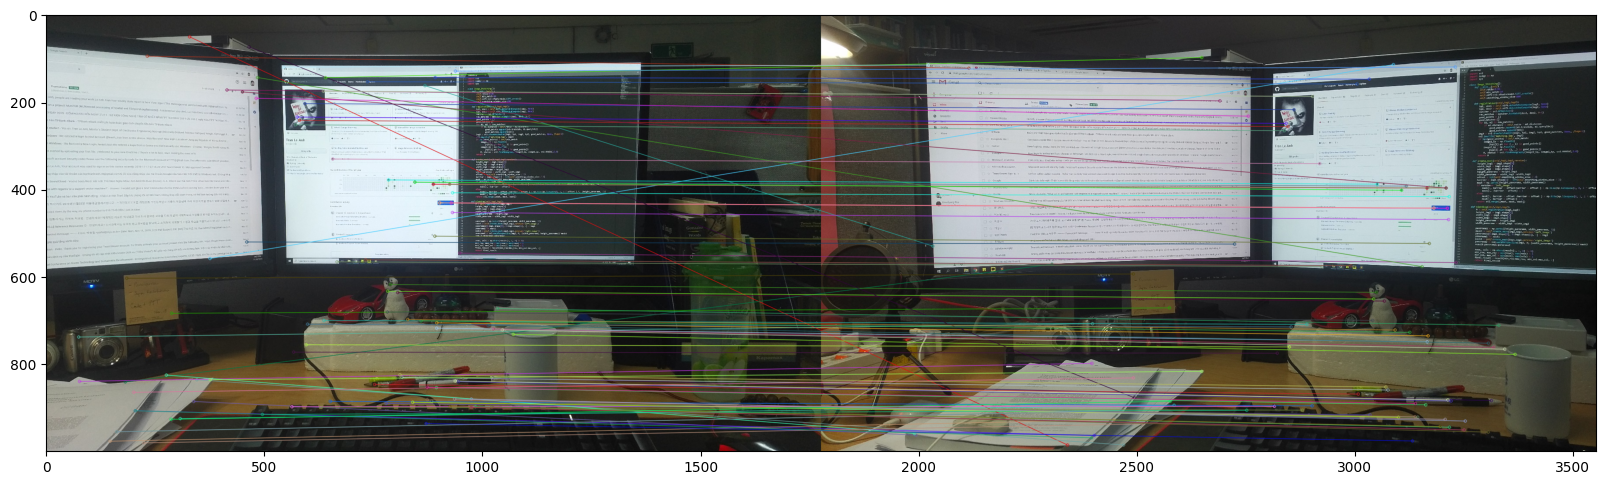

In [96]:
print(f'drawing matches for bf')
fig = plt.figure(figsize=(20, 8))
matches = keypoints_matching(features_train_image, features_query_image)
print(f'matches: {matches[0]}')
mapped_feature_image = cv2.drawMatches(train_photo, keypoints_train_image, query_photo, keypoints_query_image, matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(mapped_feature_image)
plt.savefig('./outputs/'+ 'keypoints_matched' + '.jpeg', bbox_inches='tight', dpi=300, format='jpeg')


In [97]:
def homography_stitching(keypoints_train_image, keypoints_query_image, matches, reprojThresh):
    #convert to 2 numpy array of coordinates to find hommography
    keypoints_train_image = np.float32([keypoint.pt for keypoint in keypoints_train_image])
    keypoints_query_image = np.float32([keypoint.pt for keypoint in keypoints_query_image])
    
    #minimum match count for homography is 4
    if len(matches) >= 4:
        points_train = np.float32([keypoints_train_image[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_image[m.trainIdx] for m in matches])
        
        H, status = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)
        
        return (matches, H, status)
    
    else: 
        print(f"minimum match count not satisfied cannot get homopgrahy")
        return None

In [98]:
M = homography_stitching(keypoints_train_image, keypoints_query_image, matches, reprojThresh=4)

if M is None:
    print(f"Error")
    
(matches, Homography_matrix, status) = M

#matrix with 8 degrees of freedom
print(f"{Homography_matrix}")

[[ 6.28470111e-01 -2.08777326e-02  5.82338592e+02]
 [-8.73937706e-02  8.64510095e-01  6.58370245e+01]
 [-2.09566780e-04  1.43116894e-06  1.00000000e+00]]


### Warp perspective

In [99]:
width = query_photo.shape[1] + train_photo.shape[1]
print(f"Width: {width}")

height = max(query_photo.shape[0], train_photo.shape[0])
print(f"Height: {height}")

Width: 3554
Height: 1000


results shape: (1000, 3554, 3)


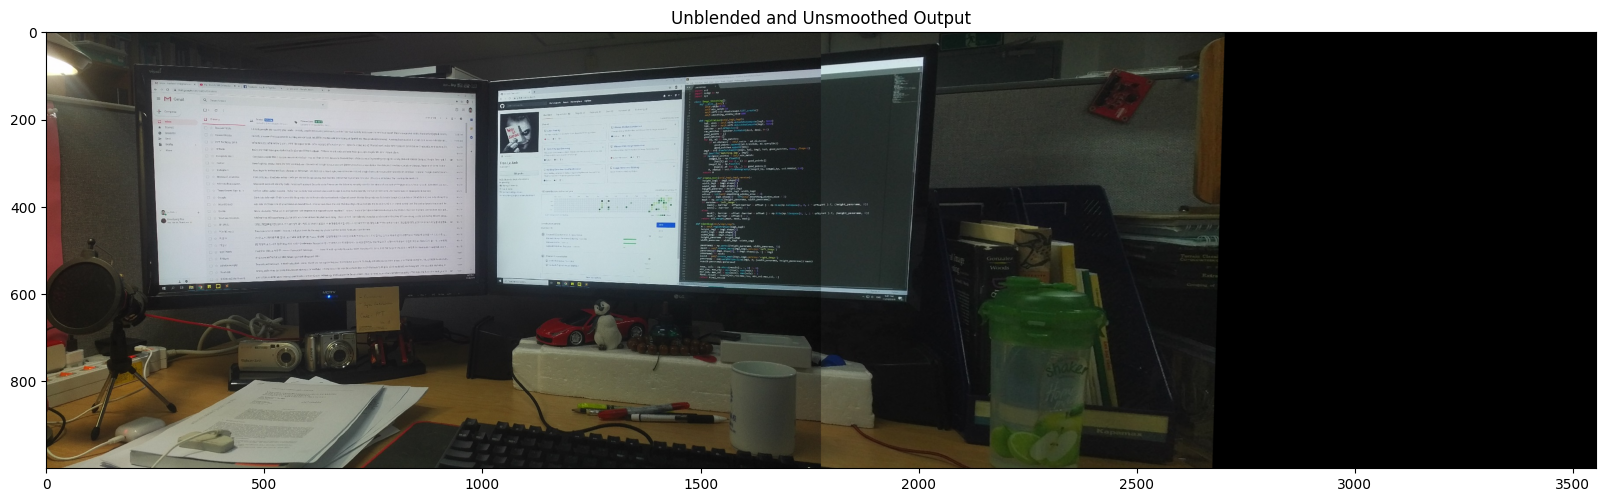

In [104]:
result = cv2.warpPerspective(train_photo, Homography_matrix, dsize=(width, height))

result[0: query_photo.shape[0], 0:query_photo.shape[1]] = query_photo
print(f"results shape: {result.shape}")

plt.figure(figsize=(20,10))
plt.title("Unblended and Unsmoothed Output")
plt.imshow(result)
plt.savefig('./outputs/'+ 'unblended_and_unsmoothed_output' + '.jpeg', bbox_inches='tight', dpi=300, format='jpeg')


### Blending and Smoothing

In [101]:
smoothing_window_size = 800
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [102]:
height_img1 = query_photo.shape[0]
width_img1 = query_photo.shape[1]
width_img2 = train_photo.shape[1]
height_panorama = height_img1
width_panorama = width_img1 +width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(query_photo,train_photo,version='left_image')
panorama1[0:query_photo.shape[0], 0:query_photo.shape[1], :] = query_photo
panorama1 *= mask1
mask2 = create_mask(query_photo,train_photo,version='right_image')
panorama2 = cv2.warpPerspective(train_photo, Homography_matrix, (width_panorama, height_panorama))*mask2
result=panorama1+panorama2

#remove extra blackspace
rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]


Final results shape: (1000, 2704, 3)


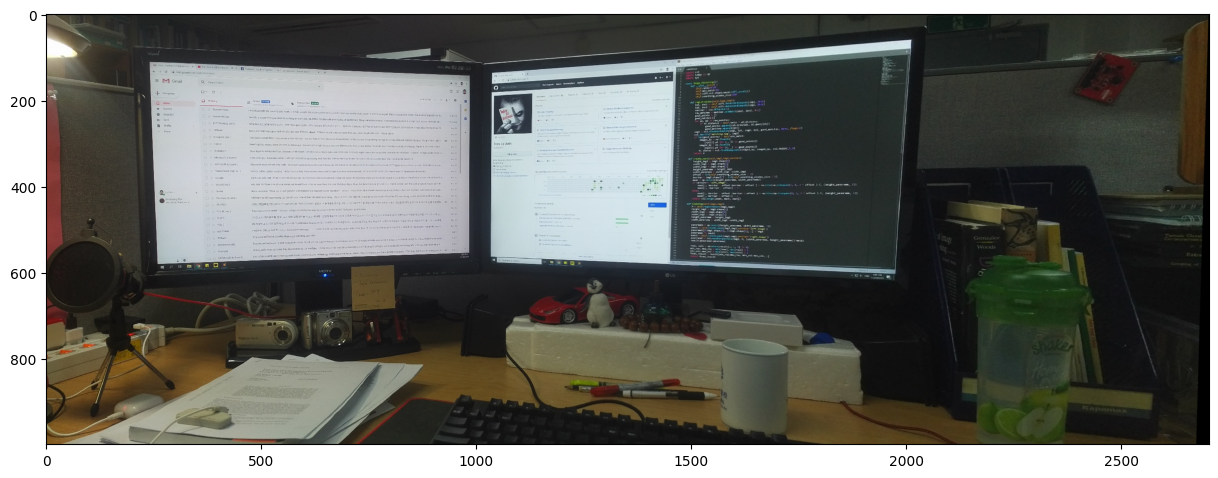

In [124]:
print(f"Final results shape: {final_result.shape}")
plt.figure(figsize=(15,10))
plt.imshow(final_result/255.0)
plt.imsave('./outputs/final_output.jpg', final_result/255.0)